In [14]:
import pandas as pd
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
from pycoingecko import CoinGeckoAPI
import time
from datetime import datetime
import json
import ast

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

cg = CoinGeckoAPI()

In [2]:
 cg.get_price(ids=['bitcoin', 'litecoin', 'ethereum'], vs_currencies='usd', include_market_cap='true', include_24hr_vol='true', include_24hr_change='true', include_last_updated_at='true')

{'bitcoin': {'usd': 29136,
  'usd_market_cap': 556671346436.0801,
  'usd_24h_vol': 69172844412.60869,
  'usd_24h_change': -2.554454557040175,
  'last_updated_at': 1652377737},
 'ethereum': {'usd': 1967.47,
  'usd_market_cap': 239755404182.52155,
  'usd_24h_vol': 46832749486.30012,
  'usd_24h_change': -9.362629163632358,
  'last_updated_at': 1652377742},
 'litecoin': {'usd': 65.04,
  'usd_market_cap': 4603738862.521969,
  'usd_24h_vol': 2005449443.945965,
  'usd_24h_change': -7.726375509655167,
  'last_updated_at': 1652377816}}

In [3]:
### List of all the coins in Coinmarket cap
df_coins = pd.read_excel('Coin-names.xlsx')
coins = df_coins['Name_Geco']

In [4]:
df_coins[df_coins['Name_Geco'] == 'alias']

,name,symbol,Lower_case,Name_Geco
2139,Alias,ALIAS,alias,alias


In [24]:
### Empty dictionary and list
df = {}
### For coins not found
not_found = []

In [28]:
## For loop to extract data
for i in coins[:]:
    time.sleep(2)
    coin = i 
    try:
        df[i] = cg.get_coin_market_chart_by_id(coin,vs_currency='usd',days = 1900)        
    except ValueError:
        #print(f'Not a valid coin {i}')
        not_found.append(i)

In [30]:
# as requested in comment
with open('panel.txt', 'w') as file:
     file.write(json.dumps(df)) # use `json.loads` to do the reverse

### Openning the txt file

In [15]:
f = open("panel.txt")
df = json.load(f)

In [16]:
#### Creating the Data Frame to store values of the dictionary
date =[]
prices = []
mk_cap = []
total_vol = []
epsilon = 0.0001
d = {'date':date,'price':prices,'mkt_cap':mk_cap,'vol':total_vol}
d = pd.DataFrame(data=d)

In [17]:
### List of all coins in the Panel
final_coins = list(df.keys())
pd.DataFrame({"Coins":final_coins}).to_excel("Final_Coins.xlsx")

In [18]:
### Boundaries for winsor-clipp
lower=0.01
higher=0.99
higher_volume = 0.995

In [19]:
### Appending all coins
for i in final_coins:
    if (i == "#metahash") or (i== "bird-money"):
        pass
    else: 
        ### Date
        date =  np.transpose(df[i]['prices'])[0]
        
        ### Prices
        prices = np.transpose(df[i]['prices'])[1].astype(float)
        mk_cap = np.transpose(df[i]['market_caps'])[1].astype(float)
        total_vol = np.transpose(df[i]['total_volumes'])[1].astype(float)
        
        ### Coin References
        coin = [str(i)]*len(prices)
        coin_ref = [final_coins.index(i)]*len(prices)
        
        ### Seting Data Frame
        frame = {'date':date,'price':prices,'mkt_cap':mk_cap,'vol':total_vol,'coin':coin, 'coin_ref': coin_ref}
        frame = pd.DataFrame(data=frame)
        
        ## Filling Na's for the particular coin with previous observation
        #frame.fillna(method="bfill")
        #frame.fillna(method="ffill")

        if len(frame[frame["price"] <= 0]) != 0:
            pass
        else:
            ## Getting Returns
            frame['returns']=frame["price"].pct_change()

            ### Getting Log-Returns
            frame['log_ret']=np.log(frame.price).diff()

            ### Check outliers and clip them
            
            #frame['returns']= frame['returns'].clip(lower=frame.returns.quantile(lower),
            #                                    upper = frame.returns.quantile(higher), axis=0)

            #frame['log_ret']= frame['log_ret'].clip(lower=frame.log_ret.quantile(lower),
            #                                    upper = frame.log_ret.quantile(higher), axis=0)            

            frame = frame[frame["vol"]>0].copy()



            ### Lagged Variables
            frame["lagged_log_ret"] = frame.log_ret.shift(1)
            frame["lagged_ret"] = frame.returns.shift(1)
            frame["lagged_vol"] = frame.vol.shift(1)
            ### Dropping first row from Frame
            frame.dropna(inplace = True)
            
            #### Amihud Ratio
            frame["AMIHUD"] = abs(frame.log_ret)/frame.vol

            frame["delta"] = frame["AMIHUD"]-frame["AMIHUD"].shift()

            ### Winzor
           # frame["vol"] = frame.vol.clip(lower=frame.vol.quantile(lower),
           #                                                 upper = frame.vol.quantile(higher_volume), axis=0)

           #frame["lagged_vol"] = frame.lagged_vol.clip(lower=frame.lagged_vol.quantile(lower),
           #                                                 upper = frame.lagged_vol.quantile(higher_volume), axis=0)

           # frame["lagged_log_ret"] = frame.lagged_log_ret.clip(lower=frame.lagged_log_ret.quantile(lower),
           #                                                 upper = frame.lagged_log_ret.quantile(higher), axis=0)

            #frame["log_ret"] = frame.log_ret.clip(lower=frame.log_ret.quantile(lower),
            #                                                upper = frame.log_ret.quantile(higher), axis=0)



            ## Concatenating Data
            d = pd.concat([d, frame])

In [20]:
### Transforming dates
d['date_ms']=pd.to_datetime(d.date,unit = "ms")
### Fix Date Formats
d['date_d']=np.transpose(np.array(pd.to_datetime(d['date_ms'], format ="Y%m%d"), dtype='datetime64[D]'))

In [21]:
### Subset the data
d_vals = d[(d['date_d']<"2022-05-11") & (d['date_d']>"2017-03-10")].copy()
d_vals.describe()

,price,mkt_cap,vol,coin_ref,returns,log_ret,lagged_log_ret,lagged_ret,lagged_vol,AMIHUD,delta
count,2.052237e+06,2.052237e+06,2.052237e+06,2.052237e+06,2.052237e+06,2.052237e+06,2.052237e+06,2.052237e+06,2.052237e+06,2.052237e+06,2.050259e+06
mean,1.651255e+02,8.873599e+08,8.938396e+07,7.812560e+02,4.592314e+38,-6.763810e-04,-5.574434e-04,4.592314e+38,8.926527e+07,6.160792e+09,-9.656281e+01
std,2.936958e+03,4.077480e+11,2.028998e+09,5.611786e+02,6.578779e+41,3.555500e-01,3.525006e-01,6.578779e+41,2.027143e+09,8.244703e+12,1.166540e+13
min,8.895748e-46,-2.914261e+08,3.041915e-15,0.000000e+00,-1.000000e+00,-1.037806e+02,-1.037806e+02,-1.000000e+00,3.041915e-15,0.000000e+00,-1.179373e+16
25%,4.243849e-03,8.837963e+03,4.327374e+03,3.100000e+02,-4.569051e-02,-4.676725e-02,-4.662106e-02,-4.555099e-02,4.340186e+03,1.890532e-08,-2.838142e-07
50%,4.195879e-02,2.314329e+06,1.192493e+05,6.790000e+02,-1.797008e-03,-1.798624e-03,-1.738387e-03,-1.736877e-03,1.194253e+05,2.720023e-07,-5.895494e-12
75%,4.510102e-01,1.882704e+07,1.314139e+06,1.152000e+03,3.924377e-02,3.849331e-02,3.853414e-02,3.928621e-02,1.315604e+06,9.647801e-06,2.578991e-07
max,3.904485e+05,5.837092e+14,9.267677e+11,2.156000e+03,9.424516e+44,1.035571e+02,1.035571e+02,9.424516e+44,9.267677e+11,1.179373e+16,1.179373e+16


In [22]:
#### Copying Data
data = d_vals.copy()
data.set_index('date_d',inplace = True)
### Creating date reference
bitcoin = d_vals[d_vals['coin']=='bitcoin']
bitcoin.reset_index(inplace = True)
bitcoin.reset_index(inplace = True)
### Setting new index
bitcoin.set_index('date_d',inplace = True)

### Time counter
data['time'] = data.index.map(bitcoin.level_0)

In [23]:
### Pre-process Number One -> All values are possitive (mkt vol and price)
### Mkt bigger than One Million
### Volume bigger than zero
dp= data[(data.mkt_cap > (10*6)) & (data.mkt_cap != 0)].copy()
#dp.dropna(inplace = True)
dp = dp[dp.coin != "blockv"]
dp.describe()

,price,mkt_cap,vol,coin_ref,returns,log_ret,lagged_log_ret,lagged_ret,lagged_vol,AMIHUD,delta,time
count,1.541414e+06,1.541414e+06,1.541414e+06,1.541414e+06,1.541414e+06,1.541414e+06,1.541414e+06,1.541414e+06,1.541414e+06,1.541414e+06,1.540757e+06,1.541340e+06
mean,1.913153e+02,8.027211e+08,1.175305e+08,7.273575e+02,3.015817e+30,-6.284527e-04,-5.905733e-04,3.015817e+30,1.173743e+08,6.079272e+06,-1.300095e+02,1.191089e+03
std,3.243637e+03,1.775196e+10,2.299340e+09,5.678190e+02,2.793657e+33,2.791376e-01,2.796685e-01,2.793657e+33,2.297168e+09,5.359912e+09,7.581682e+09,4.949319e+02
min,1.808978e-12,6.064126e+01,1.753956e-14,0.000000e+00,-9.999090e-01,-9.304295e+00,-2.116895e+01,-1.000000e+00,1.753956e-14,0.000000e+00,-6.198225e+12,0.000000e+00
25%,5.759967e-03,1.308873e+06,9.274032e+03,2.590000e+02,-4.522851e-02,-4.628325e-02,-4.616102e-02,-4.511181e-02,9.301524e+03,1.358507e-08,-1.751041e-07,7.910000e+02
50%,5.594094e-02,6.333565e+06,1.836486e+05,5.890000e+02,-2.068181e-03,-2.070323e-03,-2.024630e-03,-2.022582e-03,1.839418e+05,1.806228e-07,-3.245510e-12,1.289000e+03
75%,5.732988e-01,3.537381e+07,1.926850e+06,1.117000e+03,3.901241e-02,3.827066e-02,3.832955e-02,3.907360e-02,1.927929e+06,4.499369e-06,1.609954e-07,1.623000e+03
max,2.139518e+05,1.278798e+12,9.267677e+11,2.156000e+03,3.136202e+36,8.403608e+01,8.403608e+01,3.136202e+36,9.267677e+11,6.198225e+12,6.198225e+12,1.885000e+03


In [24]:
dp.coin.unique()[100:120]

array(['radium', 'matchpool', 'salus', 'novacoin', 'digitalnote',
       'monetaryunit', 'chronobank', 'vericoin', 'infinitecoin',
       'feathercoin', 'primecoin', 'bitcny', 'xtrabytes', 'einsteinium',
       'sphere', 'pluton', 'bitcoin-plus', 'ion', 'megacoin', 'espers'],
      dtype=object)

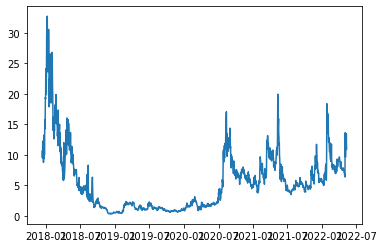

In [25]:
plt.plot(dp[dp.coin=='pluton'].price)

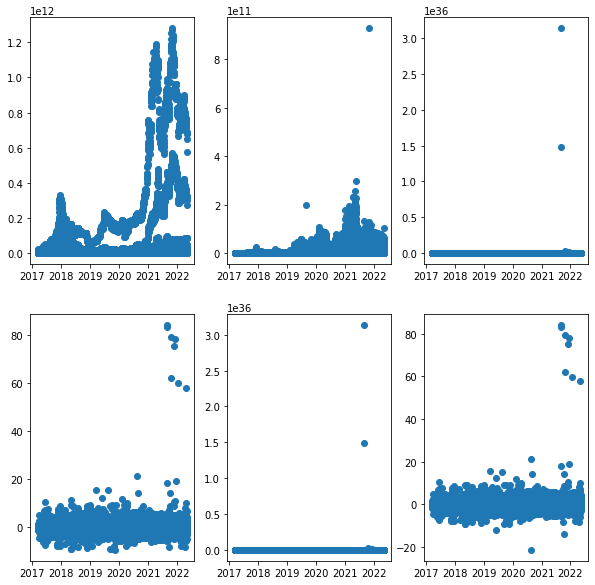

In [26]:
fig, axs = plt.subplots(2,3, figsize = (10,10))
axs[0,0].scatter(dp.date_ms,dp.mkt_cap)
axs[0,1].scatter(dp.date_ms,dp.vol)
axs[0,2].scatter(dp.date_ms,dp.returns)
axs[1,0].scatter(dp.date_ms,dp.log_ret)
axs[1,1].scatter(dp.date_ms,dp.lagged_ret)
axs[1,2].scatter(dp.date_ms,dp.lagged_log_ret)
plt.show()

In [27]:
### Setting Variables
dp = dp.loc[:,["price","mkt_cap","vol","log_ret","lagged_log_ret","lagged_vol","AMIHUD","delta","coin_ref","time","date_ms","coin"]]
dp.head()

,price,mkt_cap,vol,log_ret,lagged_log_ret,lagged_vol,AMIHUD,delta,coin_ref,time,date_ms,coin
date_d,,,,,,,,,,,,
2017-03-11,1181.204123,1.914753e+10,1.690714e+08,0.071215,-0.079672,4.170869e+08,4.212099e-10,2.301892e-10,0.0,0.0,2017-03-11,bitcoin
2017-03-12,1230.560000,1.995002e+10,1.046134e+08,0.040935,0.071215,1.690714e+08,3.912976e-10,-2.991227e-11,0.0,1.0,2017-03-12,bitcoin
2017-03-13,1243.264922,2.015819e+10,1.314036e+08,0.010272,0.040935,1.046134e+08,7.816808e-11,-3.131296e-10,0.0,2.0,2017-03-13,bitcoin
2017-03-14,1246.556739,2.021404e+10,8.680731e+07,0.002644,0.010272,1.314036e+08,3.046081e-11,-4.770727e-11,0.0,3.0,2017-03-14,bitcoin
2017-03-15,1258.457000,2.040926e+10,7.276398e+07,0.009501,0.002644,8.680731e+07,1.305760e-10,1.001151e-10,0.0,4.0,2017-03-15,bitcoin


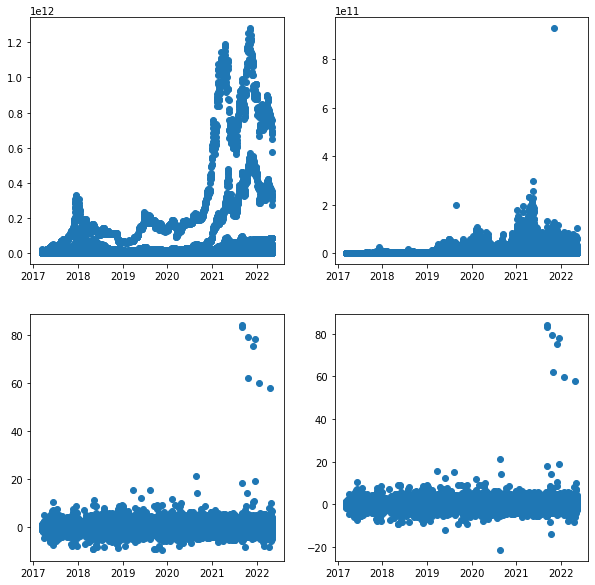

In [28]:
fig, axs = plt.subplots(2,2, figsize = (10,10))
axs[0,0].scatter(dp.index,dp.mkt_cap)
axs[0,1].scatter(dp.index,dp.vol)
axs[1,0].scatter(dp.index,dp.log_ret)
axs[1,1].scatter(dp.index,dp.lagged_log_ret)
plt.show()

In [29]:
dp.to_pickle("Panel_millions_no_win.pkl")